In [2]:
import sys, os
sys.path.append(os.path.join('..', 'scripts'))
import figure_utils as utils
import lif_utils

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
# Simple 1D Tuning

rng = np.random.RandomState(3122)

N = 10
r = 1.0
x_intercepts = rng.uniform(-0.95, 0.95, N)
max_rates = rng.uniform(50, 100, N)
J_max = lif_utils.lif_rate_inv(max_rates)
J_0 = lif_utils.lif_rate_inv(1e-3)

gain = (J_max - J_0) / (r - x_intercepts)
bias = (r * J_0 - x_intercepts * J_max) / (r - x_intercepts)
encoders = rng.choice([-1, 1], N).reshape(N, 1)

xs_1d = np.linspace(-1, 1, 1000).reshape(-1, 1)
Js_1d = gain * (xs_1d @ encoders.T) + bias
As_1d = lif_utils.lif_rate(Js_1d)

In [5]:
# Bell-shaped tuning curves

rng = np.random.RandomState(3122)

gain = (J_max - J_0) / (r - x_intercepts)
bias = (r * J_0 - x_intercepts * J_max) / (r - x_intercepts)
phis = rng.uniform(-np.pi, np.pi, N)
encoders = np.array((
    np.sin(phis), np.cos(phis)
)).T

xs_2d = np.array((
    np.sin(np.pi * xs_1d), np.cos(np.pi * xs_1d)
)).T[0]
Js_2d = gain * (xs_2d @ encoders.T) + bias
As_2d = lif_utils.lif_rate(Js_2d)

In [6]:
# Hex SSPs (just some random code Andreas wrote back in 2020, feel free to copy)

def ssp_basis_vector_unitary(q, phis=None, rng=np.random, return_fft=False):
    if phis is None:
        phis = rng.uniform(-np.pi, np.pi, (q - 1) // 2)
    else:
        phis = np.atleast_1d(phis)
        assert len(phis) == (q - 1) // 2
    half = (np.cos(phis) + 1j * np.sin(phis))
    res = np.concatenate((
        (1.0,),
        half,
        tuple() if (q & 1) else (1.0,),
        np.conj(half[::-1]),
    ))
    return res if return_fft else np.real(np.fft.ifft(res))

def ssp_basis_fft(d, q, rng=np.random):
    return np.array([ssp_basis_vector_unitary(q, rng=rng, return_fft=True) for _ in range(d)])

def ssp_encode(x, B):
    return np.real(np.fft.ifft(np.prod(np.power(B, np.asarray(x)[:, :, None]), axis=1)))

def ssp_cc(x, y):
    return np.real(np.fft.ifft(np.fft.fft(x) * np.fft.fft(y)))

def pnt_2d_to_3d_plane(x, theta=0.0):
    # See eq. 3.27 in Brent's thesis
    M = np.array((
        (np.cos(theta), np.cos(theta + 2.0 * np.pi / 3.0), np.cos(theta + 4.0 * np.pi / 3.0)),
        (np.sin(theta), np.sin(theta + 2.0 * np.pi / 3.0), np.sin(theta + 4.0 * np.pi / 3.0)),
    ))
    return x @ M

def get_hex_activities():
    x0 = pnt_2d_to_3d_plane(np.zeros((1, 2)))

    r = 5.0
    N = 1001
    xs, ys = np.linspace(-r, r, N), np.linspace(-r, r, N)
    xss, yss = np.meshgrid(xs, ys)
    smpls2d = np.array((xss.flatten(), yss.flatten())).T
    smpls3d = pnt_2d_to_3d_plane(smpls2d)

    phi = 3.0
    B = np.array([
        ssp_basis_vector_unitary(7, [phi, 0.0, 0.0], return_fft=True),
        ssp_basis_vector_unitary(7, [0.0, phi, 0.0], return_fft=True),
        ssp_basis_vector_unitary(7, [0.0, 0.0, phi], return_fft=True),
    ])

    centre = ssp_encode(x0, B)
    ssp_sim = np.zeros(xss.shape)
    ssp_sim = np.einsum('...i,...i->...', ssp_encode(smpls3d, B), centre).reshape(*xss.shape)

    return xs, ys, lif_utils.lif_rate(ssp_sim * 3.0)

hex_ssp_xs, hex_ssp_ys, hex_ssp_As = get_hex_activities()

Saving to tuning_curves_examples.large.pdf
Extracting bounding box of file tuning_curves_examples.large.pdf
Optimising PDF and saving to tuning_curves_examples.pdf


GPL Ghostscript 9.56.1: Can't embed the complete font LibertinusT1Math as it is too large, embedding a subset.
GPL Ghostscript 9.56.1: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.
GPL Ghostscript 9.56.1: Can't embed the complete font LinBiolinumTB as it is too large, embedding a subset.


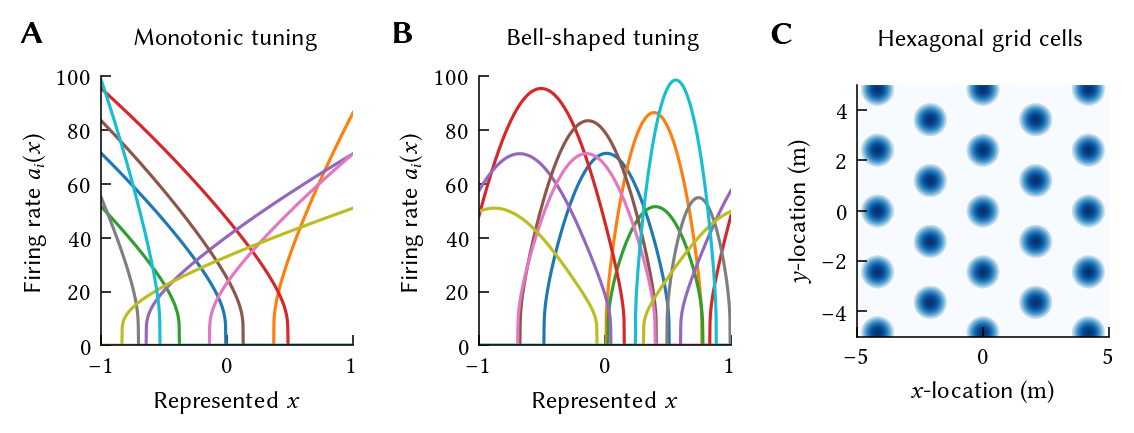

In [10]:
fig, axs = plt.subplots(
    1, 3, figsize=(6.5, 1.75), gridspec_kw={
        "wspace": 0.5
    })
axs[0].plot(xs_1d, As_1d);
axs[0].set_ylim(0, 100)
axs[0].set_xlim(-1, 1)
axs[0].set_xlabel("Represented $x$")
axs[0].set_ylabel("Firing rate $a_i(x)$")
axs[0].set_title("{Monotonic tuning}", y=1.055)

axs[1].plot(xs_1d, As_2d)
axs[1].set_ylim(0, 100)
axs[1].set_xlim(-1, 1)
axs[1].set_xlabel("Represented $x$")
axs[1].set_ylabel("Firing rate $a_i(x)$")
axs[1].set_title("{Bell-shaped tuning}", y=1.055)


axs[2].imshow(hex_ssp_As, vmin=0.0, vmax=100.0, extent=[
    -5.0, 5.0, -5.0, 5.0
], cmap='Blues')
axs[2].set_xlabel("$x$-location ($\\mathrm{m}$)")
axs[2].set_ylabel("$y$-location ($\\mathrm{m}$)")
axs[2].set_title("{Hexagonal grid cells}", y=1.09)

fig.text(0.0625, 0.975, "\\textbf{A}", fontsize=12, ha="left", va="baseline")
fig.text(0.35, 0.975, "\\textbf{B}", fontsize=12, ha="left", va="baseline")
fig.text(0.64, 0.975, "\\textbf{C}", fontsize=12, ha="left", va="baseline")

utils.save(fig, "tuning_curves_examples.pdf")